In [5]:
# imports

import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [14]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start="2012-01-01", end="2022-12-31")[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 132 entries, 2012-01 to 2022-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  132 non-null    float64
 1   SMB     132 non-null    float64
 2   HML     132 non-null    float64
 3   RMW     132 non-null    float64
 4   CMA     132 non-null    float64
 5   RF      132 non-null    float64
dtypes: float64(6)
memory usage: 7.2 KB


In [15]:
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2012-01,5.05,2.06,-0.97,-2.01,-1.43,0.00
2012-02,4.42,-1.71,0.43,-0.48,-0.01,0.00
2012-03,3.11,-0.47,1.14,-0.54,0.74,0.00
2012-04,-0.85,-0.55,-0.78,1.30,0.65,0.00
2012-05,-6.19,-0.12,-1.07,2.08,2.31,0.01


In [9]:
# Getting S&P 500 data

# Get the list of constituents in the S&P 500 index
sp500_constituents = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500_constituents['Symbol'].tolist()

# Define the start and end dates for the historical data
start_date = "2012-01-01"
end_date = "2022-12-31"

# Create a dictionary to store the historical data for each stock
stock_data_dict = {}

# Fetch historical data for each stock
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1wk")  # Weekly data
        stock_data_dict[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

sample_ticker = tickers[0]
print(stock_data_dict[sample_ticker].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
# We can condense all these dataframes into a single one with the same date range and the assets as columns

# Create a new dataframe to store the adjusted close price of the stocks
adj_close_df = pd.DataFrame(index=stock_data_dict[sample_ticker].index)

# Add the adjusted close price of each stock to the dataframe
for ticker in stock_data_dict.keys():
    adj_close_df[ticker] = stock_data_dict[ticker]['Adj Close']

# Remove columns with more than 5% missing values
adj_close_df = adj_close_df.dropna(axis=1, thresh=int(len(adj_close_df) * 0.95))

adj_close_df.head()

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4834/3479445365.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_close_df[ticker] = stock_data_dict[ticker]['Adj Close']
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4834/3479445365.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_close_df[ticker] = stock_data_dict[ticker]['Adj Close']
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4834/3479445365.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

,MMM,AOS,ABT,ACN,ADM,ADBE,ADP,AES,AFL,A,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.253696,8.729011,21.054647,41.559456,21.189959,28.719999,36.851585,8.727821,16.468285,24.123596,...,14.257357,82.181068,154.473175,79.616554,18.521334,21.462807,34.390095,35.110001,47.478519,14.079092
2012-01-08,57.411621,8.829390,20.892576,42.698063,21.262850,28.969999,36.898582,9.027554,16.073702,25.194330,...,14.689402,81.674316,159.634735,80.294037,18.214914,21.855053,35.183033,34.970001,48.410843,14.765488
2012-01-15,58.819450,8.647449,21.198303,44.750782,21.897015,30.500000,38.134129,9.320147,17.834435,26.445660,...,15.012131,81.040840,162.840347,85.967125,18.112774,22.477541,36.072678,37.580002,49.299198,15.044830
2012-01-22,60.062435,8.839844,20.916977,45.239910,21.736652,31.049999,37.160461,9.141735,18.255074,27.529287,...,14.861169,81.779869,156.777969,88.647316,18.371527,22.008543,36.286289,37.900002,53.213226,13.480491
2012-01-29,60.247871,9.463789,20.909369,46.755390,21.539841,31.850000,37.274620,9.220234,18.604996,29.206331,...,15.459788,82.898979,164.796265,85.602318,18.058306,23.048859,36.857861,39.279999,54.981129,14.390363


In [30]:
# Compute the monthly returns dataframe

returns = adj_close_df.pct_change().dropna()

monthly_returs = returns.resample('M').last()
monthly_returs.head()

,MMM,AOS,ABT,ACN,ADM,ADBE,ADP,AES,AFL,A,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.003087,0.070583,-0.000364,0.033499,-0.009054,0.025765,0.003072,0.008587,0.019168,0.060919,...,0.040281,0.013684,0.051144,-0.034350,-0.017049,0.047269,0.015752,0.036412,0.033223,0.067495
2012-02-29,-0.007710,-0.014407,0.012169,-0.000838,-0.010013,0.009578,0.011520,-0.022464,0.003838,0.016271,...,0.032412,-0.002552,0.003907,0.077646,-0.006043,-0.024212,0.010681,-0.012681,-0.031667,-0.006868
2012-03-31,0.008479,0.023685,0.014735,-0.005857,-0.006278,0.014789,0.003637,0.011610,0.005905,0.004740,...,0.020874,-0.001712,0.000419,-0.013352,0.021199,0.020220,0.007645,0.015536,0.012443,-0.012425
2012-04-30,-0.007722,-0.045857,0.006775,-0.037065,0.037645,-0.028886,-0.040487,-0.029719,-0.037414,-0.036419,...,-0.027654,-0.014666,-0.052060,-0.056576,-0.003325,-0.068006,-0.029596,0.005312,0.002063,-0.042615
2012-05-31,-0.022765,-0.017181,-0.027791,-0.037605,-0.041240,-0.056329,-0.033410,-0.056574,-0.014534,-0.068032,...,-0.057199,-0.018367,-0.029139,-0.045668,0.005755,-0.045614,-0.080966,-0.046199,-0.050129,-0.033927


In [32]:
# Align the data

ff_factor_data = ff_factor_data.loc[monthly_returs.index[0]:monthly_returs.index[-1]]
ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2012-01,5.05,2.06,-0.97,-2.01,-1.43,0.00
2012-02,4.42,-1.71,0.43,-0.48,-0.01,0.00
2012-03,3.11,-0.47,1.14,-0.54,0.74,0.00
2012-04,-0.85,-0.55,-0.78,1.30,0.65,0.00
2012-05,-6.19,-0.12,-1.07,2.08,2.31,0.01


# The easy way

In [35]:
mod = LinearFactorModel(portfolios=monthly_returs, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                451   R-squared:                      0.1012
No. Factors:                          6   J-statistic:                    409.18
No. Observations:                   132   P-value                         0.8873
Date:                  Sun, Nov 19 2023   Distribution:                chi2(445)
Time:                          15:34:15                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.6410     0.8671     0.7393     0.4597     -1.0584      2.3404
SMB            0.4807     0.5517    

In [63]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                451   R-squared:                      0.1012
No. Factors:                          6   J-statistic:                    409.18
No. Observations:                   132   P-value                         0.8873
Date:                  Sun, Nov 19 2023   Distribution:                chi2(445)
Time:                          15:34:15                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.6410     0.8671     0.7393     0.4597     -1.0584      2.3404
SMB            0.4807     0.5517    

# The harder way, ff macbeth regression

In [41]:
ff_factor_data = ff_factor_data.drop('RF', axis=1) # Remove the risk-free rate

# Set ff_factor_data index to the same as monthly_returns
ff_factor_data.index = monthly_returs.index

ff_factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2012-01-31,5.05,2.06,-0.97,-2.01,-1.43
2012-02-29,4.42,-1.71,0.43,-0.48,-0.01
2012-03-31,3.11,-0.47,1.14,-0.54,0.74
2012-04-30,-0.85,-0.55,-0.78,1.30,0.65
2012-05-31,-6.19,-0.12,-1.07,2.08,2.31


In [42]:
# Step 1: N time series regression (N = # portfolios/assets) of excess returns on factors to estimate factor loadings
betas = []
for ticker in monthly_returs.columns:
    step1 = OLS(endog=monthly_returs[ticker],
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params)

In [44]:
betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=monthly_returs.columns)
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
MMM,0.001364,0.000465,-0.001379,0.000748,0.001064
AOS,0.001896,0.002135,-0.001965,0.001412,0.002192
ABT,0.001602,-0.001278,-0.003125,-0.001482,0.004221
ACN,0.002690,-0.000752,-0.001079,-0.001995,0.002020
ADM,0.001251,-0.000226,-0.000653,-0.000070,0.001674


In [45]:
# Step 2: T cross-sectional regression (T = # time periods) to estimate risk premia
# Risk factor premia is the time average, we can get a t-stat to assess each factor's significance under the assumption
# that each premia is independent over time...

lambdas = []
for period in monthly_returs.index:
    step2 = OLS(endog=monthly_returs.loc[period, betas.index],
                exog=betas).fit()
    lambdas.append(step2.params)

In [47]:
lambdas = pd.DataFrame(lambdas, columns=betas.columns.tolist(), index=monthly_returs.index)
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2012-01-31,13.457503,3.814221,-0.429850,-3.251382,-1.820099
2012-02-29,1.669332,-0.948090,0.082908,-0.768664,-1.796542
2012-03-31,4.154304,-2.193049,-2.976366,1.140838,-0.738919
2012-04-30,-8.895368,-3.714856,-2.797885,3.831890,-2.630658
2012-05-31,-12.859141,-4.917582,-1.353935,3.708379,-1.532818


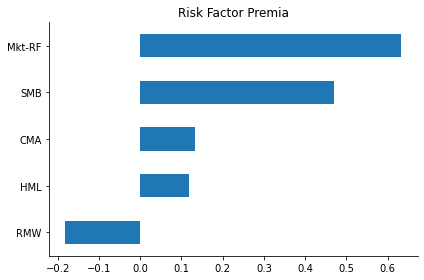

In [49]:
lambdas.mean().sort_values().plot.barh(title='Risk Factor Premia')
sns.despine()
plt.tight_layout()

## W

Same results as the LinearFactorModel output

In [51]:
t = lambdas.mean() / lambdas.std()
print("t-statistics for each factor: (these are the factor risk premia estimates divided by their standard errors)")
t

t-statistics for each factor: (these are the factor risk premia estimates divided by their standard errors)


Mkt-RF    0.070491
SMB       0.091102
HML       0.024014
RMW      -0.061679
CMA       0.040565
dtype: float64

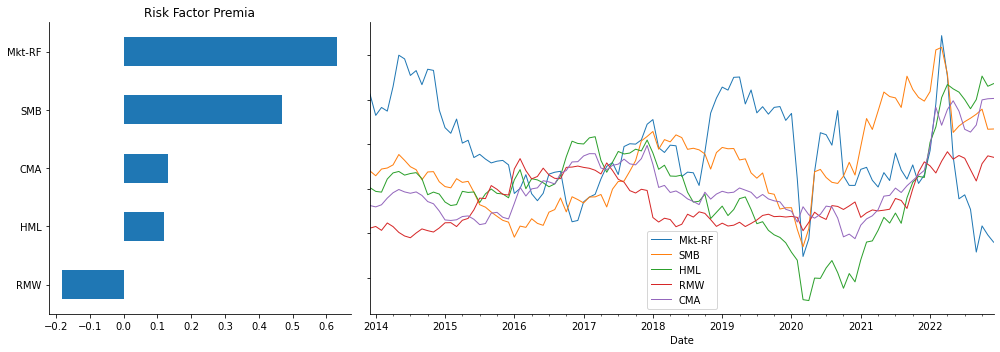

In [61]:
window = 24
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(title='Risk Factor Premia', ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1, sharey=True, ax=ax2, figsize=(14, 5))
sns.despine()
plt.tight_layout()

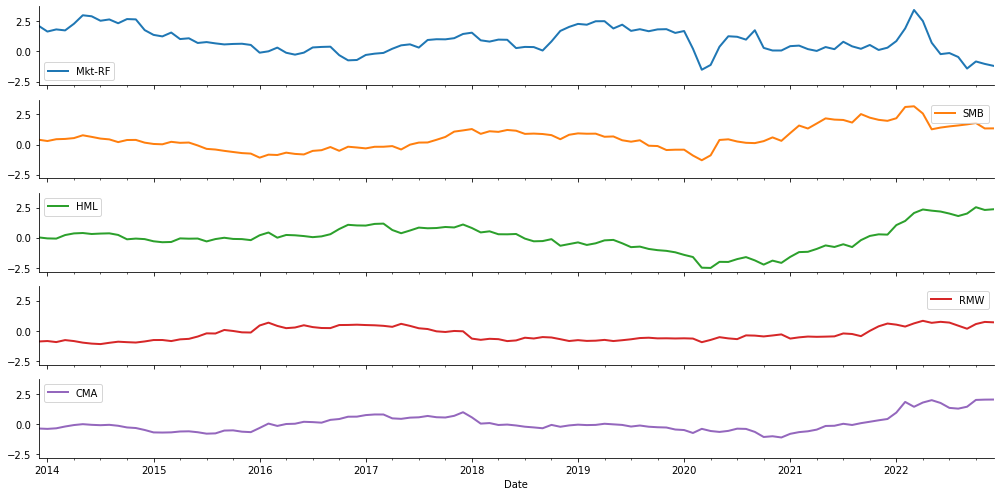

In [62]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()